# Eclat

In [1]:
options(repr.plot.width=16, repr.plot.height=12)

## Support

**Support** is a key metric, which measures the frequency of an itemset in the dataset. It helps determine which itemsets are frequent enough to be considered for generating association rules.

$$
Support(A) = \frac{Transactions \space containing \space A}{Total \space transactions}
$$

Where:
- $A$ is an itemset (e.g., `{Diapers, Beer}`).
- The numerator represents the number of transactions that contain $A$.
- The denominator represents the total number of transactions in the dataset.


# Dataset

Each row in the dataset represents a shopping trip made by a different customer. It includes all the items they bought in that transaction, just like a receipt from a store. This helps us understand which products are often purchased together, making it useful for analyzing shopping patterns and creating better recommendations.

## Libraries Loading

In [2]:
#install.packages("arules")
#install.packages("arulesViz")

In [3]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
suppressMessages(library(arules))
suppressMessages(library(arulesViz))

## Data Loading

> **Note!** There is no header in the dataset.

Have a look at the data.

In [4]:
data <- read.csv("../00_data/Market_Basket_Optimisation.csv", header = FALSE)
head(data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
2,burgers,meatballs,eggs,,,,,,,,,,,,,,,,,
3,chutney,,,,,,,,,,,,,,,,,,,
4,turkey,avocado,,,,,,,,,,,,,,,,,,
5,mineral water,milk,energy bar,whole wheat rice,green tea,,,,,,,,,,,,,,,
6,low fat yogurt,,,,,,,,,,,,,,,,,,,


In [5]:
dim(data)

[1] 7501   20

In [6]:
glimpse(data)

Rows: 7,501
Columns: 20
$ V1  <chr> "shrimp", "burgers", "chutney", "turkey", "mineral water", "low fa…
$ V2  <chr> "almonds", "meatballs", "", "avocado", "milk", "", "french fries",…
$ V3  <chr> "avocado", "eggs", "", "", "energy bar", "", "", "shallot", "green…
$ V4  <chr> "vegetables mix", "", "", "", "whole wheat rice", "", "", "", "", …
$ V5  <chr> "green grapes", "", "", "", "green tea", "", "", "", "", "", "", "…
$ V6  <chr> "whole weat flour", "", "", "", "", "", "", "", "", "", "", "", ""…
$ V7  <chr> "yams", "", "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ V8  <chr> "cottage cheese", "", "", "", "", "", "", "", "", "", "", "", "", …
$ V9  <chr> "energy drink", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ V10 <chr> "tomato juice", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ V11 <chr> "low fat yogurt", "", "", "", "", "", "", "", "", "", "", "", "", …
$ V12 <chr> "green tea", "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ V13 <chr> "hon

## Data Preprocessing

In [7]:
transactions <- read.transactions("../00_data/Market_Basket_Optimisation.csv", sep = ",", rm.duplicates = TRUE)
transactions

distribution of transactions with duplicates:
1 
5 


transactions in sparse format with
 7501 transactions (rows) and
 119 items (columns)

In [8]:
summary(transactions)

transactions as itemMatrix in sparse format with
 7501 rows (elements/itemsets/transactions) and
 119 columns (items) and a density of 0.03288973 

most frequent items:
mineral water          eggs     spaghetti  french fries     chocolate 
         1788          1348          1306          1282          1229 
      (Other) 
        22405 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1754 1358 1044  816  667  493  391  324  259  139  102   67   40   22   17    4 
  18   19   20 
   1    2    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.914   5.000  20.000 

includes extended item information - examples:
             labels
1           almonds
2 antioxydant juice
3         asparagus

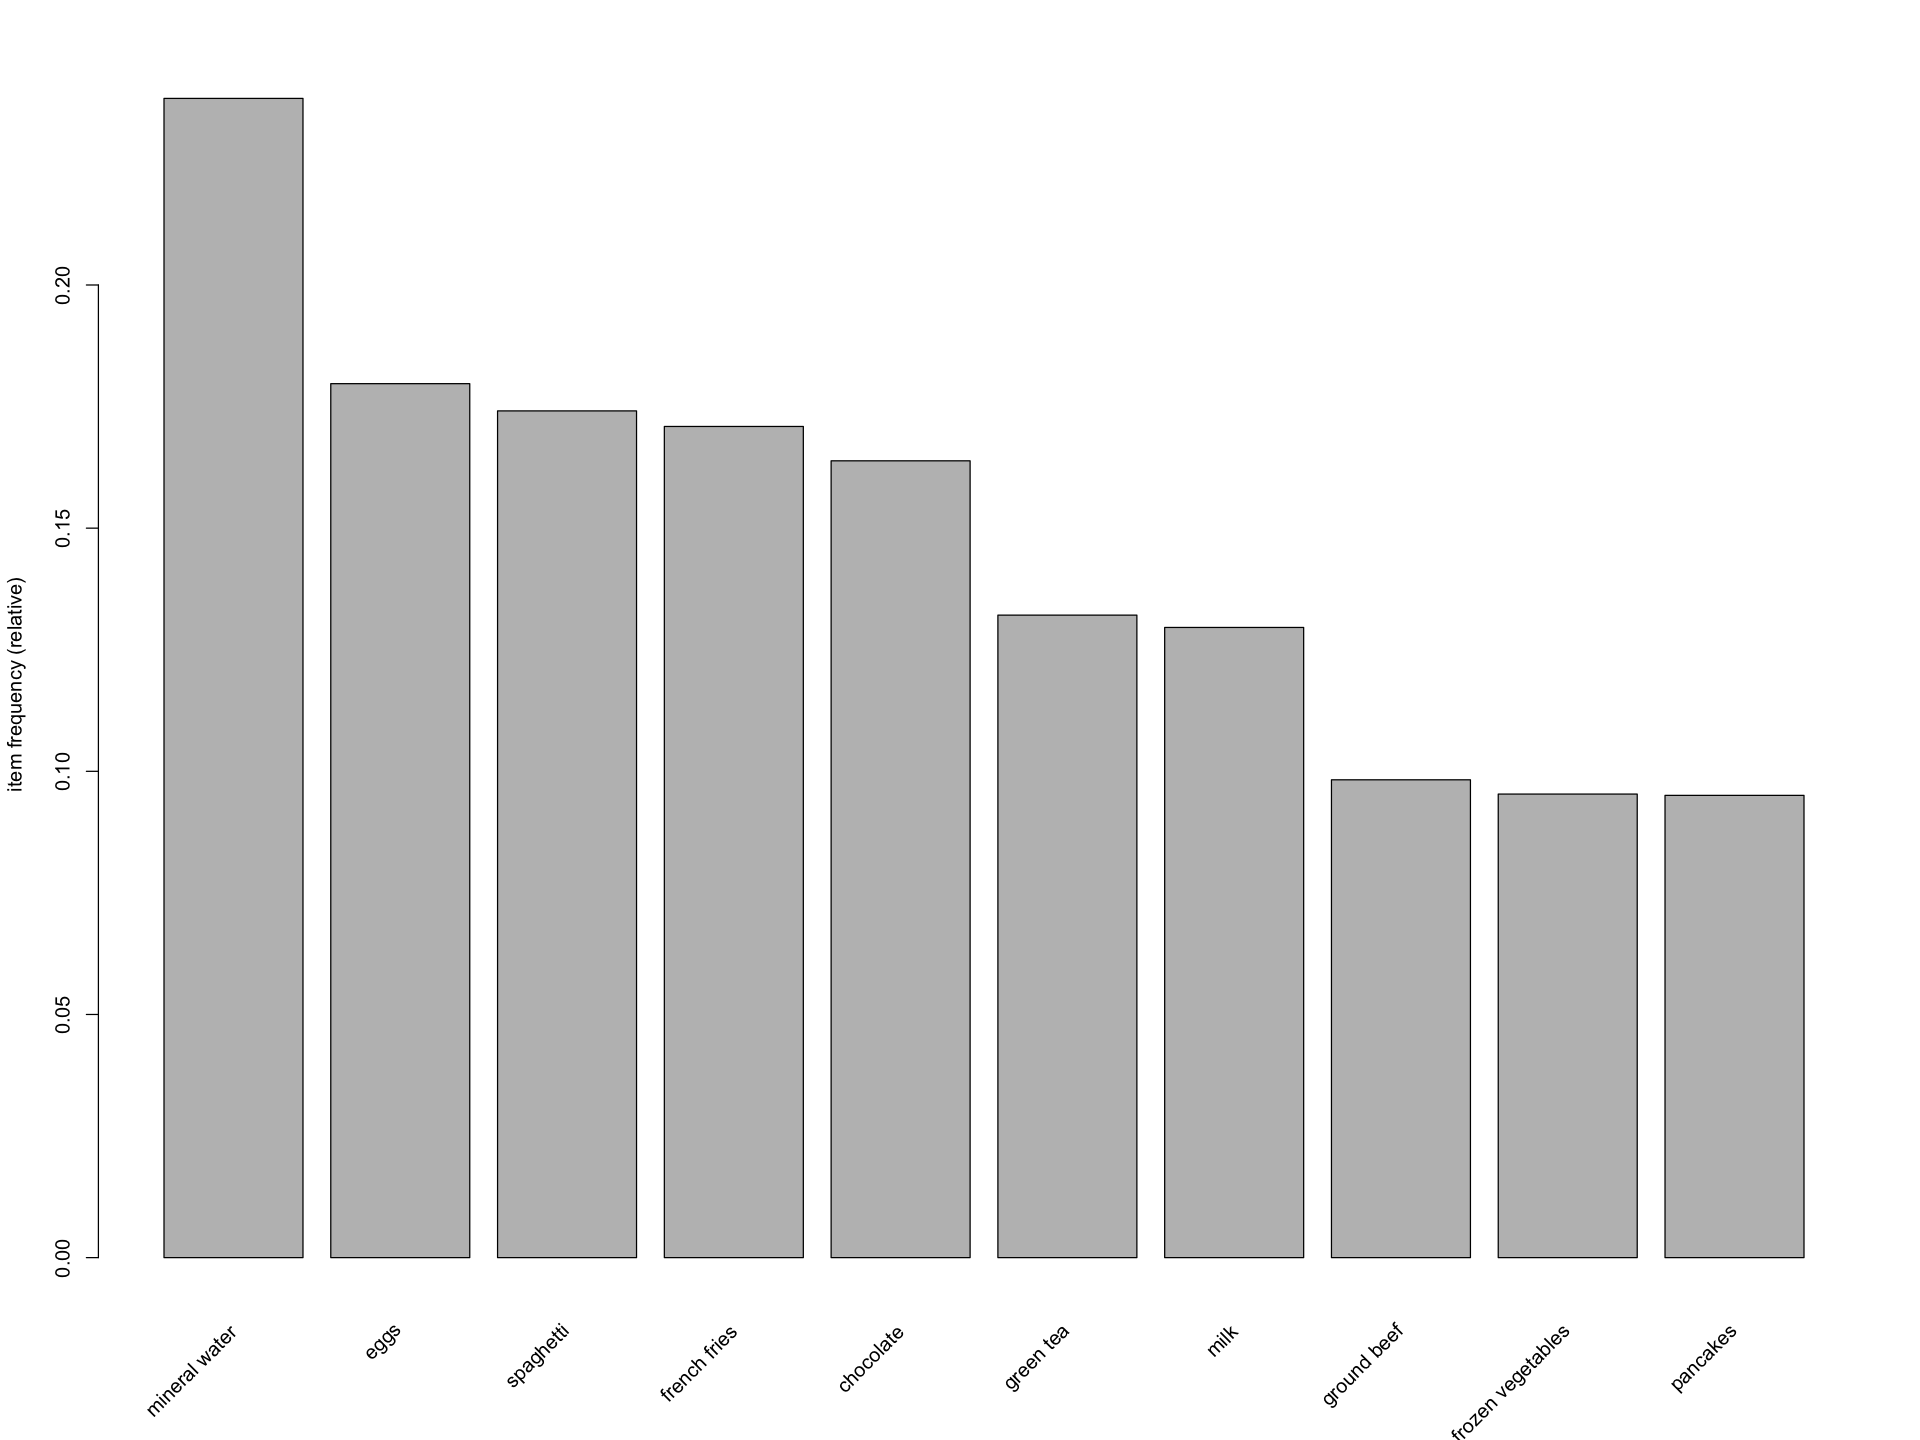

In [9]:
# Top 10 of products
itemFrequencyPlot(transactions, topN = 10)

## Frequaent itemsets

### Find the optimal minimal support

In [10]:
# find elbow point
find_elbow <- function(x, y) {
  second_derivative <- diff(diff(y))
  elbow_idx <- which.max(second_derivative) + 1  # Adjust index
  return(x[elbow_idx])
}

[1] "Optimal min support: 0.002"


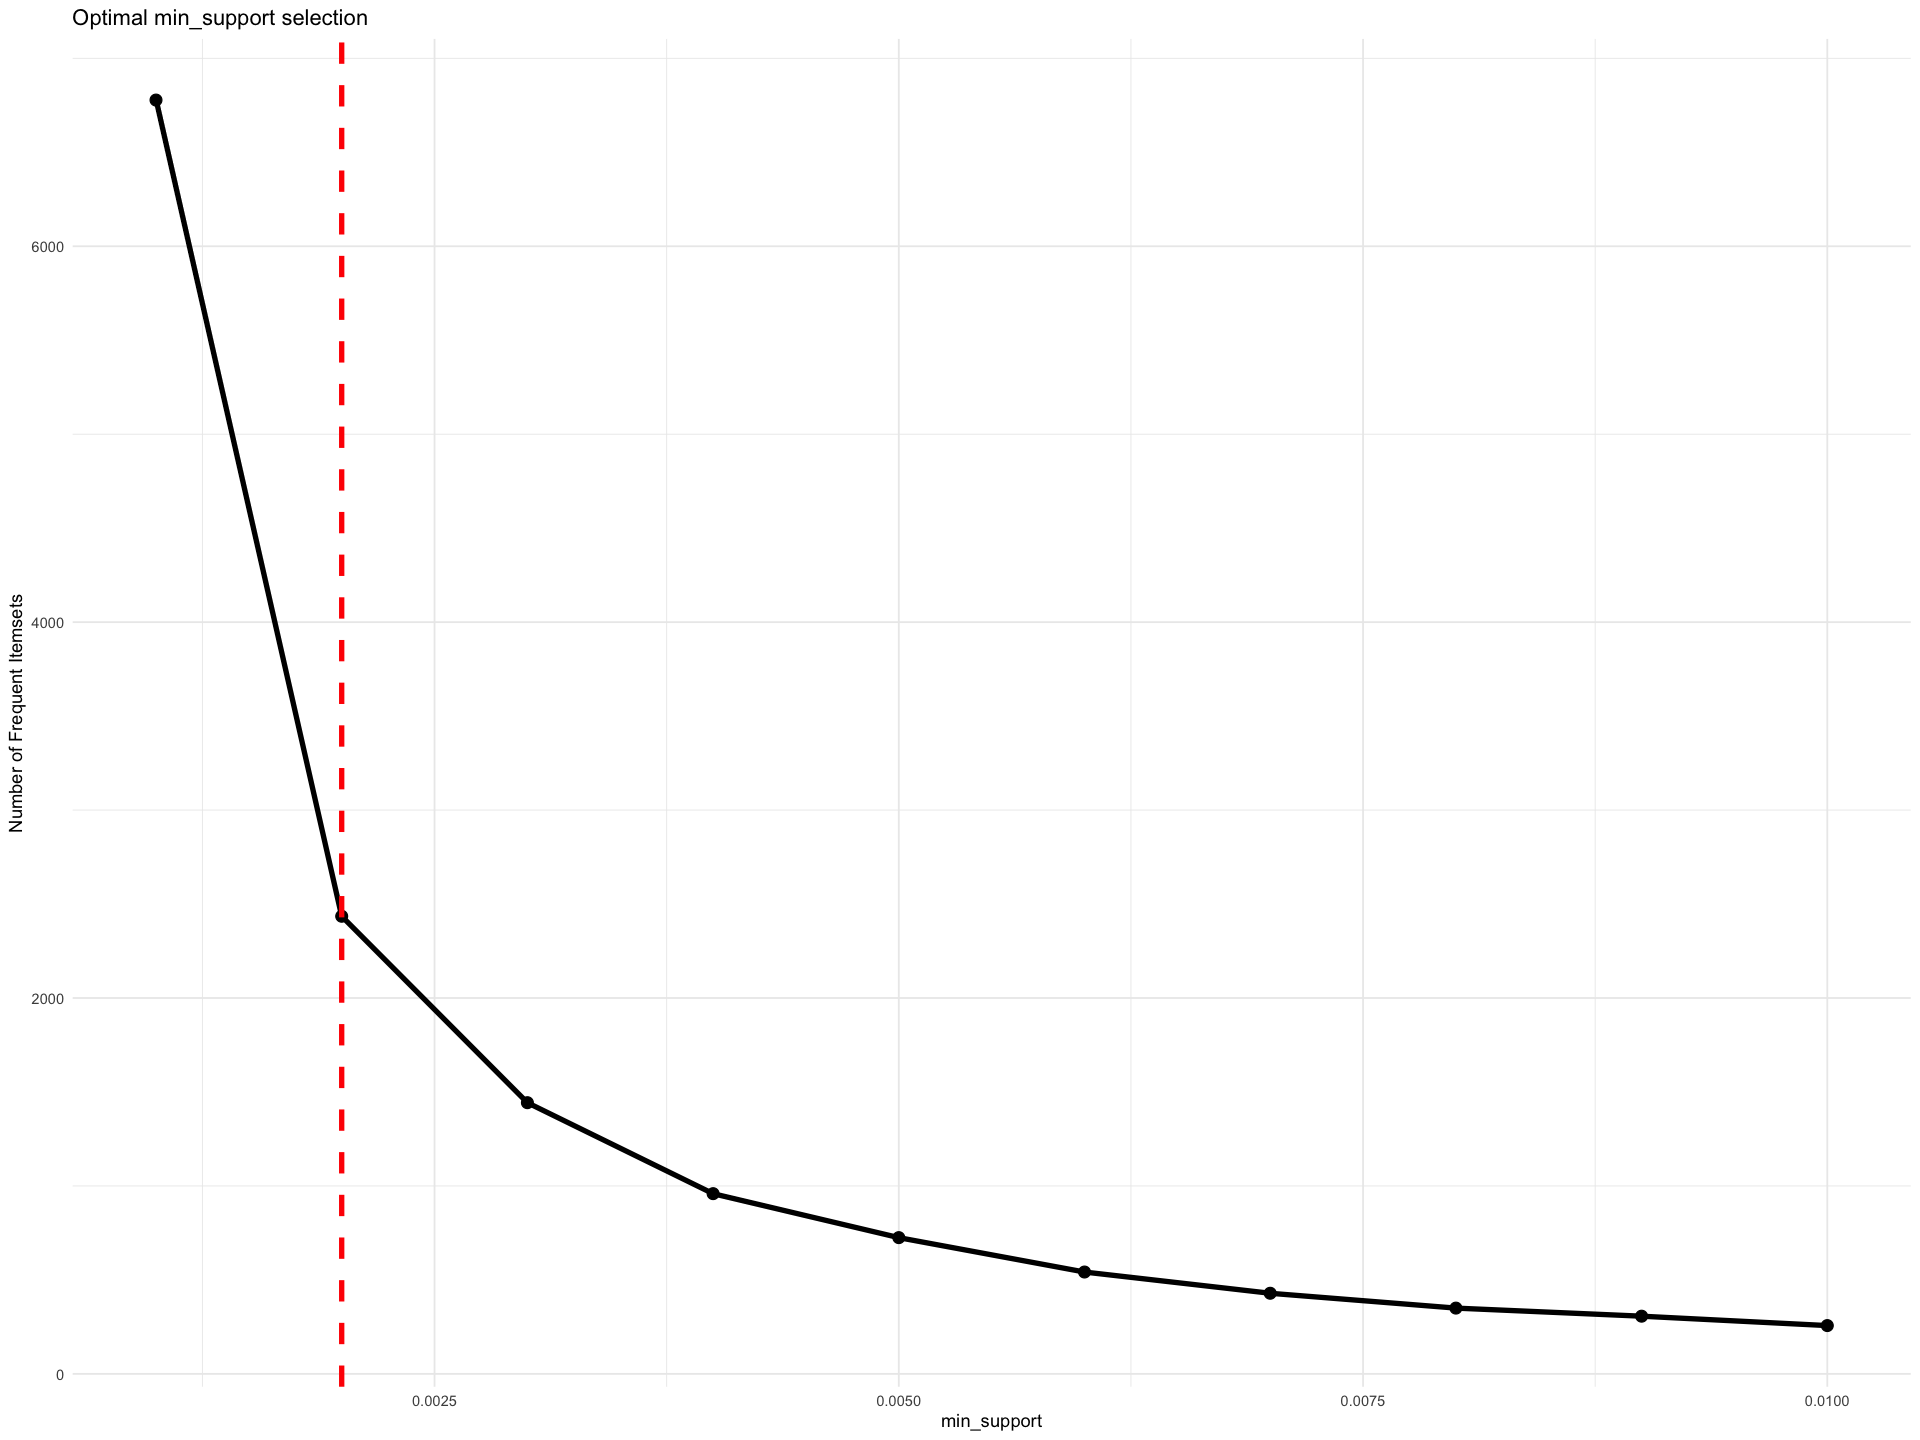

In [11]:
support_values <- seq(0.001, 0.01, length.out = 10)
# store the support values
results <- numeric(length(support_values))

for (i in seq_along(support_values)) {
  min_sup <- support_values[i]
  frequent_itemsets <- eclat(transactions, 
                               parameter = list(support = min_sup), 
                               control = list(verbose = FALSE))
  results[i] <- length(frequent_itemsets)
}

min_support <- find_elbow(support_values, results)
print(paste("Optimal min support:", min_support))

# Plot the results
ggplot(data.frame(support_values, results), aes(x = support_values, y = results)) +
  geom_line(linewidth = 1.5) +
  geom_point(size = 3) +
  geom_vline(xintercept = min_support, linetype = "dashed", color = "red", linewidth = 1.5) +
  labs(x = "min_support", y = "Number of Frequent Itemsets", 
       title = "Optimal min_support selection") +
  theme_minimal()


+ If `min_support` is too **low**, many itemsets appear, including insignificant ones.
+ If `min_support` is too **high**, useful patterns may disappear.
+ The optimal `min_support` is found at the "elbow" of the graph, where the curve sharply drops and then stabilizes.

The value $0.002$ is the optimal value of `min_support`.

In [12]:
itemsets <- eclat(transactions, 
                 parameter = list(support = min_support,
                                  minlen=2,
                                  maxlen=2),
                control = list(verbose = FALSE))

itemsets

set of 1143 itemsets 

### View association rules

In [13]:
# top 10 rules ordered by lift
inspect(sort(itemsets, by = 'support')[1:10])

     items                              support    count
[1]  {mineral water, spaghetti}         0.05972537 448  
[2]  {chocolate, mineral water}         0.05265965 395  
[3]  {eggs, mineral water}              0.05092654 382  
[4]  {milk, mineral water}              0.04799360 360  
[5]  {ground beef, mineral water}       0.04092788 307  
[6]  {ground beef, spaghetti}           0.03919477 294  
[7]  {chocolate, spaghetti}             0.03919477 294  
[8]  {eggs, spaghetti}                  0.03652846 274  
[9]  {eggs, french fries}               0.03639515 273  
[10] {frozen vegetables, mineral water} 0.03572857 268  


In [14]:
# interactive table
library(DT)
itemsets_df <- as(itemsets, "data.frame")
datatable(itemsets_df, options = list(pageLength = 10))

HTML widgets cannot be represented in plain text (need html)

In [15]:
# just table ordered by lift
library(knitr)
itemsets_df <- as(sort(itemsets, by = 'support'), "data.frame")
kable(head(itemsets_df, 10)) 



|     |items                             |   support| count|
|:----|:---------------------------------|---------:|-----:|
|1143 |{mineral water,spaghetti}         | 0.0597254|   448|
|1138 |{chocolate,mineral water}         | 0.0526596|   395|
|1141 |{eggs,mineral water}              | 0.0509265|   382|
|1129 |{milk,mineral water}              | 0.0479936|   360|
|1116 |{ground beef,mineral water}       | 0.0409279|   307|
|1117 |{ground beef,spaghetti}           | 0.0391948|   294|
|1139 |{chocolate,spaghetti}             | 0.0391948|   294|
|1142 |{eggs,spaghetti}                  | 0.0365285|   274|
|1136 |{eggs,french fries}               | 0.0363951|   273|
|1108 |{frozen vegetables,mineral water} | 0.0357286|   268|

## Viz association rules

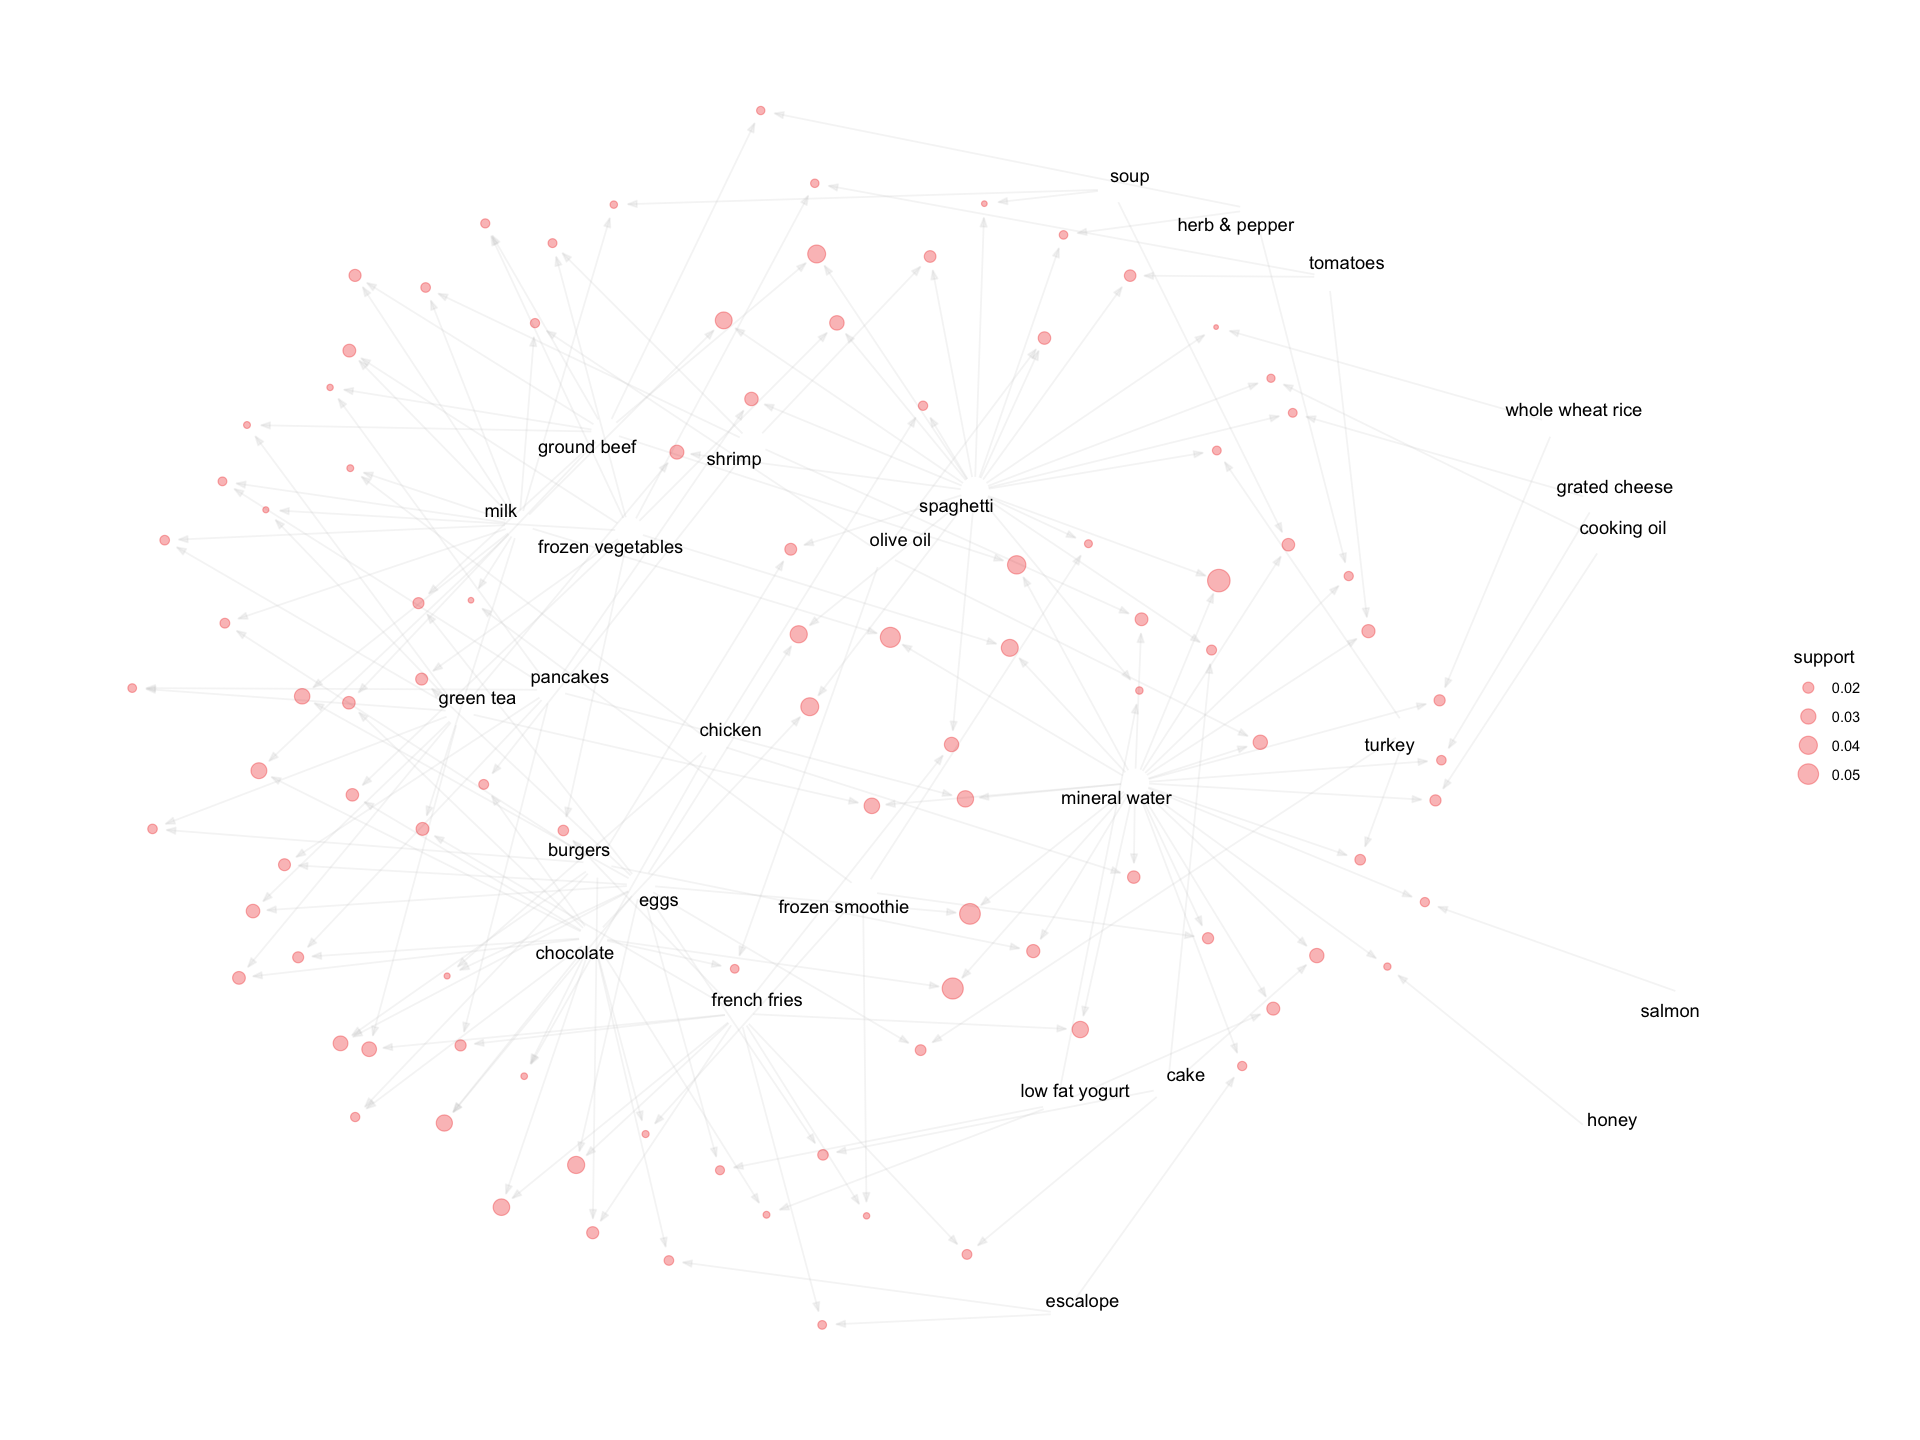

In [16]:
plot(sort(itemsets, by = 'support')[1:100], 
     method="graph")

In [17]:
# interactive plot
plot(sort(itemsets, by = 'support')[1:100], 
     method="graph", 
     engine="htmlwidget")

HTML widgets cannot be represented in plain text (need html)

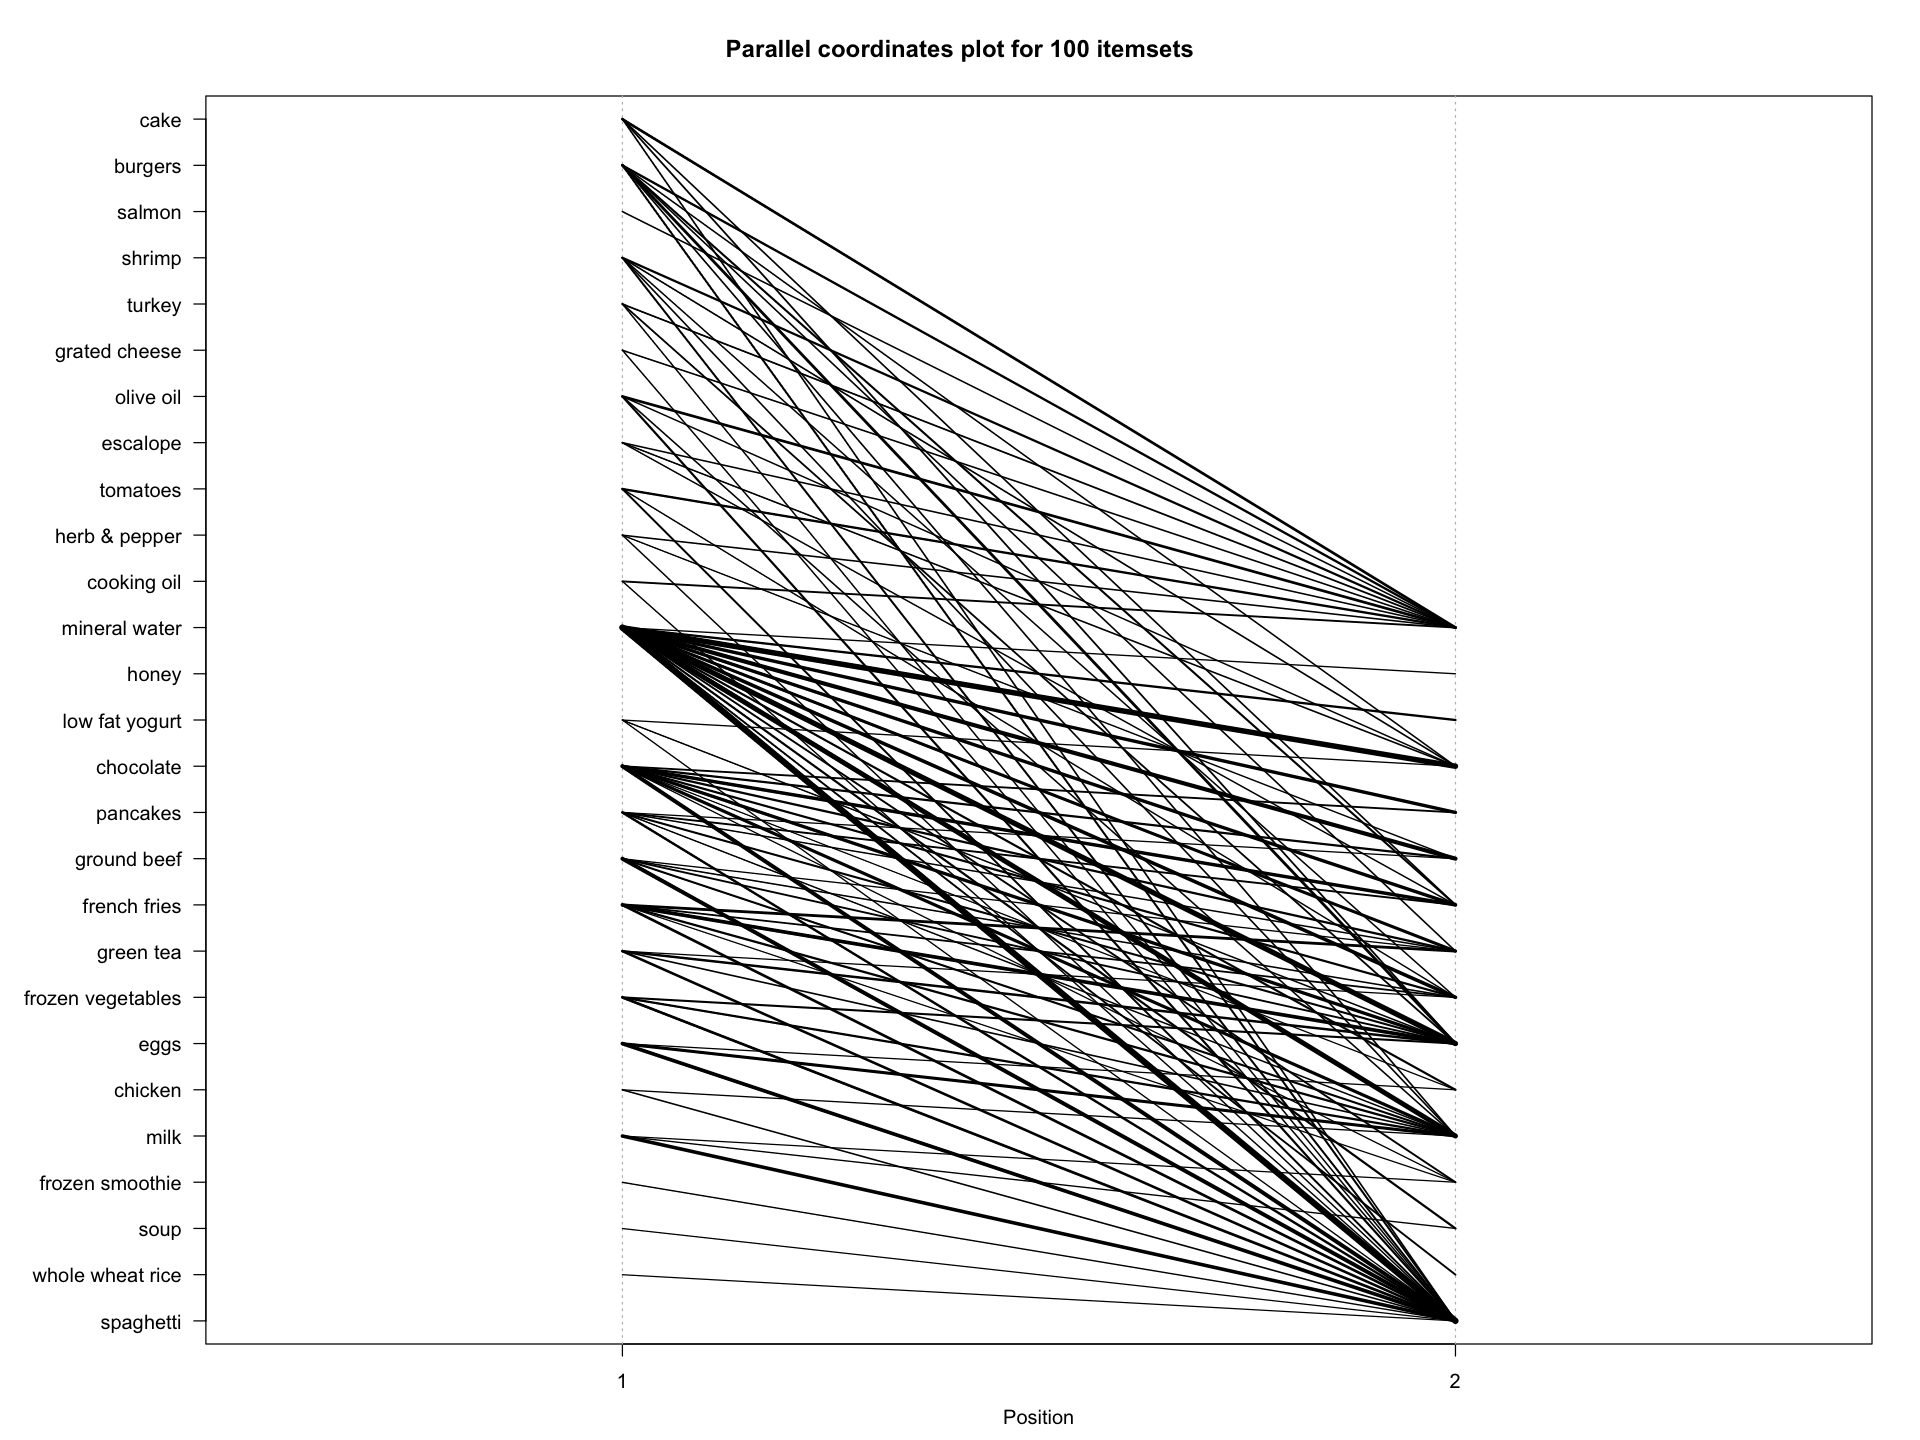

In [18]:
options(repr.plot.width=16, repr.plot.height=12)
plot(sort(itemsets, by = 'support')[1:100], method="paracoord", control=list(reorder = TRUE))